In [2]:
import logging
import pprint
import torch
import random

import lightning as pl
from lightning.pytorch.loggers.csv_logs import CSVLogger
from torch.utils.data import DataLoader, Subset

from neural_bandits.bandits.linear_ucb_bandit import LinearUCBBandit
from neural_bandits.benchmark.datasets.statlog import StatlogDataset
from neural_bandits.utils.selectors import EpsilonGreedySelector

from neural_bandits.benchmark.environment import BanditBenchmarkEnvironment
from neural_bandits.benchmark.logger_decorator import OnlineBanditLoggerDecorator

In [ ]:
dataset = StatlogDataset()
print(dataset.context_size)
print(len(dataset))

63
58000


In [5]:
batch_size = 1

train_loader = DataLoader(Subset(dataset, range(10000)), batch_size=batch_size, shuffle=True)

accelerator = "cpu"
env = BanditBenchmarkEnvironment(train_loader, device=accelerator)

bandit_module = LinearUCBBandit(
    n_features=dataset.context_size,
    selector=EpsilonGreedySelector(epsilon=0.1),
).to(accelerator)


logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.FATAL)
logger = OnlineBanditLoggerDecorator(CSVLogger("logs", name="linear_bandit", flush_logs_every_n_steps=100))

In [6]:
for contextualized_actions in env:
    chosen_actions, _ = bandit_module.forward(contextualized_actions)

    trainer = pl.Trainer(
        max_epochs=1,
        logger=logger,
        log_every_n_steps=1,
        enable_progress_bar=False,
        enable_model_summary=False,
        enable_checkpointing=True,
        accelerator=accelerator,
    )
    feedback = env.get_feedback(chosen_actions)
    batch_regret = env.compute_regret(chosen_actions)
    logger.pre_training_log({"regret": batch_regret})

    batch_dataloader = DataLoader(feedback, batch_size=batch_size)
    trainer.fit(bandit_module, batch_dataloader)
    # Because of this: https://github.com/Lightning-AI/pytorch-lightning/issues/10294,
    # we need to move the model to the desired device.
    bandit_module = bandit_module.to(accelerator)

Step: 0 {'training_run': 1, 'reward': 1.0, 'epoch': 0, 'regret': 0.0}

c:\Users\Parisa\anaconda3\envs\neural_bandits\lib\site-packages\lightning\pytorch\core\optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
c:\Users\Parisa\anaconda3\envs\neural_bandits\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Step: 9998 {'training_run': 9999, 'reward': 0.0, 'epoch': 0, 'regret': 1.0}

In [10]:
checkpoint_path = logger._logger_wrappee.log_dir + "/bandit_checkpoint.ckpt"
trainer.save_checkpoint(checkpoint_path)
print(f"Model saved to {checkpoint_path}")

Model saved to logs\linear_bandit\version_8/bandit_checkpoint.ckpt


In [11]:
checkpoint_path = "logs\\linear_bandit\\version_8/bandit_checkpoint.ckpt"

checkpoint = torch.load(checkpoint_path, map_location="cpu")
    
pp = pprint.PrettyPrinter(indent=4)

print("Top-level keys in checkpoint:")
print(list(checkpoint.keys()))

print("\nHyperparameters:")
pp.pprint(checkpoint.get('hyper_parameters', {}))

print("\nModel state_dict keys:")
if 'state_dict' in checkpoint:
    pp.pprint(list(checkpoint['state_dict'].keys()))

print("\nPrecision matrix shape:")
if 'precision_matrix' in checkpoint:
    pp.pprint(checkpoint['precision_matrix'].shape)
    print("Sample values:")
    pp.pprint(checkpoint['precision_matrix'][0:2, 0:2])

print("\nParameter b shape:")
if 'b' in checkpoint:
    pp.pprint(checkpoint['b'].shape)
    print("Sample values:")
    pp.pprint(checkpoint['b'][:5])

print("\nParameter theta shape:")
if 'theta' in checkpoint:
    pp.pprint(checkpoint['theta'].shape)
    print("Sample values:")
    pp.pprint(checkpoint['theta'][:5])

print("\nSelector information:")
if 'selector_type' in checkpoint:
    pp.pprint(checkpoint['selector_type'])
    
    if checkpoint['selector_type'] == 'EpsilonGreedySelector':
        print("\nEpsilon value:")
        pp.pprint(checkpoint.get('selector_epsilon', None))
    elif checkpoint['selector_type'] == 'TopKSelector':
        print("\nK value:")
        pp.pprint(checkpoint.get('selector_k', None))

print("\nDiagonal approximation flag:")
diagonal_approx = checkpoint.get('diagonal_precision_approx', False)
pp.pprint(diagonal_approx)

Top-level keys in checkpoint:
['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers', 'hparams_name', 'hyper_parameters', 'precision_matrix', 'b', 'theta', 'selector_type', 'selector_epsilon', 'selector_generator_state']

Hyperparameters:
{'alpha': 1.0, 'eps': 0.01, 'lazy_uncertainty_update': False, 'n_features': 63}

Model state_dict keys:
['precision_matrix', 'b', 'theta']

Precision matrix shape:
torch.Size([63, 63])
Sample values:
tensor([[0.9225, 0.0106],
        [0.0106, 0.6080]])

Parameter b shape:
torch.Size([63])
Sample values:
tensor([5.9963e+05, 4.9800e+02, 2.7810e+05, 4.6280e+03, 2.8838e+05])

Parameter theta shape:
torch.Size([63])
Sample values:
tensor([ 15546.1719, -16373.9844,   2280.5625,   8645.9355,  12777.7891])

Selector information:
'EpsilonGreedySelector'

Epsilon value:
0.1

Diagonal approximation flag:
False


C:\Users\Parisa\AppData\Local\Temp\ipykernel_31284\3848726081.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location="cpu"

In [12]:
loaded_bandit = LinearUCBBandit.load_from_checkpoint(
    checkpoint_path,
    n_features=dataset.context_size,
)
print("Model loaded successfully!")

Model loaded successfully!


In [21]:
context, label = dataset[random.randint(0, len(dataset) - 1)]
contextualized_actions = context.unsqueeze(0)

chosen_actions, _ = loaded_bandit(contextualized_actions)
predicted_arm = chosen_actions.argmax(dim=1).item()

true_arm = label.argmax() if isinstance(label, torch.Tensor) else label

print(f"True best action/arm: {true_arm}")
print(f"Model predicted action/arm: {predicted_arm}")
print(f"Correct prediction: {true_arm == predicted_arm}")
print(f"Full model prediction: {chosen_actions}")

True best action/arm: 4
Model predicted action/arm: 0
Correct prediction: False
Full model prediction: tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0]])


In [ ]:
# load metrics from the logger and plot
import pandas as pd
import numpy as np

metrics_csv = logger.log_dir + "/metrics.csv"
print(metrics_csv)
metrics = pd.read_csv(metrics_csv)
cumulative_reward = np.cumsum(metrics["reward"][:10000])
cumulative_regret = np.cumsum(metrics["regret"][:10000].dropna())

logs\linear_bandit\version_8/metrics.csv


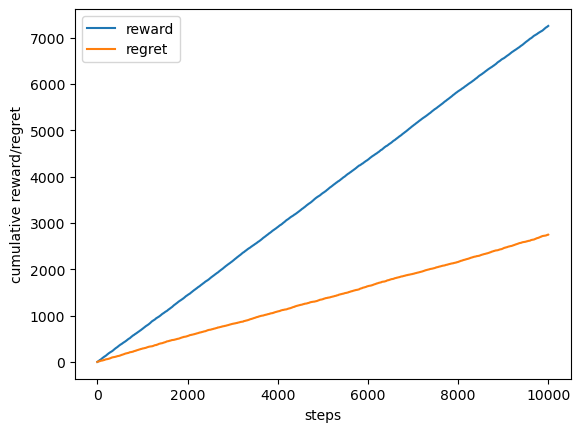

In [8]:
import matplotlib.pyplot as plt

plt.plot(cumulative_reward, label="reward")
plt.plot(cumulative_regret, label="regret")
plt.xlabel("steps")
plt.ylabel("cumulative reward/regret")
plt.legend()
plt.show()

In [9]:
# average reward
print(sum(metrics["reward"][:100]) / 100)
print(sum(metrics["reward"][:1000]) / 1000)
print(sum(metrics["reward"][:10000]) / 10000)
print(sum(metrics["regret"][:100].dropna()) / 100)
print(sum(metrics["regret"][:1000].dropna()) / 1000)
print(sum(metrics["regret"][:10000].dropna()) / 10000)

0.72
0.711
0.7254
0.28
0.289
0.2746
